Processing folder: C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence\claude.ipynb
Processing folder: C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence\non_violence
Processing folder: C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence\violence
Training the autoencoder...
Epoch 1/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 177s 257ms/step - accuracy: 0.6364 - loss: 0.0354 - val_accuracy: 0.7853 - val_loss: 0.0046
Epoch 2/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 158s 233ms/step - accuracy: 0.7855 - loss: 0.0043 - val_accuracy: 0.8637 - val_loss: 0.0036
Epoch 3/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 159s 235ms/step - accuracy: 0.8596 - loss: 0.0034 - val_accuracy: 0.8754 - val_loss: 0.0030
Epoch 4/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 159s 234ms/step - accuracy: 0.8694 - loss: 0.0030 - val_accuracy: 0.8770 - val_loss: 0.0028
Epoch 5/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 162s 238ms/step - accuracy: 0.8707 - loss: 0.0028 - val_accuracy: 0.8346 - val_loss: 0.0026
Epoch 6/15
679/679 

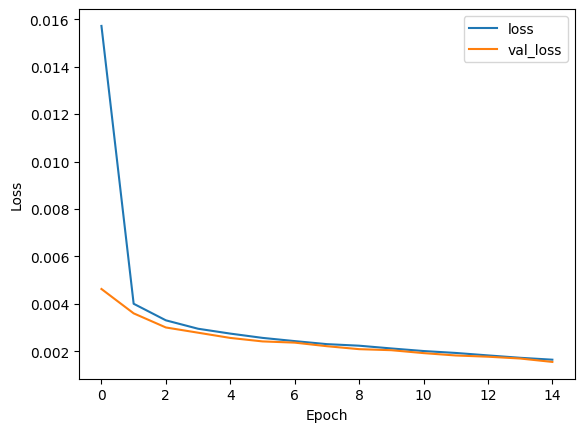

Testing the autoencoder...
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step
Accuracy: 0.46658639373871164
Precision: 1.0
Recall: 0.46658639373871164
F1 Score: 0.6362889983579638


In [6]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Function to load the violence dataset (you need to adjust the path)
def load_violence_dataset(path):
    videos = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        print(f"Processing folder: {folder_path}")
        if os.path.isdir(folder_path):
            label = 1 if 'violence' in folder.lower() else 0  # 1: Violence, 0: Non-violence
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png')):
                    image_path = os.path.join(folder_path, file)
                    try:
                        image = cv2.imread(image_path)
                        if image is None:
                            print(f"Failed to load image {image_path}. Skipping...")
                            continue

                        image = cv2.resize(image, (224, 224))  # Resize to the model input size
                        videos.append(image)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                        continue
    videos = np.array(videos)
    labels = np.array(labels)
    return videos, labels

# Preprocess the dataset
def preprocess_data(images):
    images = images.astype('float32') / 255.0
    return images

# Autoencoder Model
def create_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

# Compile the model
def compile_autoencoder(autoencoder):
    autoencoder.compile(optimizer=Adam(learning_rate=0.0001), 
                        loss='mean_squared_error',
                        metrics=['accuracy'])

# Train the autoencoder model
def train_autoencoder(autoencoder, train_images, val_images):
    batch_size = 8
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = autoencoder.fit(train_images, train_images,  # Autoencoders train to reconstruct the input
                              validation_data=(val_images, val_images),
                              epochs=15,
                              batch_size=batch_size,
                              callbacks=[early_stopping])
    return history

# Test the model and calculate performance metrics
def test_autoencoder(autoencoder, test_images, true_labels, threshold=0.02):
    reconstructions = autoencoder.predict(test_images)
    
    # Compute reconstruction error
    errors = np.mean(np.abs(reconstructions - test_images), axis=(1, 2, 3))
    anomalies = errors > threshold
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, anomalies)
    precision = precision_score(true_labels, anomalies)
    recall = recall_score(true_labels, anomalies)
    f1 = f1_score(true_labels, anomalies)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    return errors, anomalies, accuracy, precision, recall, f1

# Main function to execute the workflow
def main():
    dataset_path = r'C:\Users\abhishik chebrolu\Downloads\AINN pro\archive\new_violence'  # Update with the actual dataset path
    
    # Load the dataset and labels
    images, labels = load_violence_dataset(dataset_path)
    images = preprocess_data(images)
    
    # Split into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
    
    # Further split training data into training and validation sets (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)
    
    # Create and compile the autoencoder model
    input_shape = (224, 224, 3)
    autoencoder = create_autoencoder(input_shape)
    compile_autoencoder(autoencoder)
    
    # Train the autoencoder
    print("Training the autoencoder...")
    history = train_autoencoder(autoencoder, X_train, X_val)
    
    # Plot training history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Test the autoencoder and calculate accuracy, precision, recall, F1
    print("Testing the autoencoder...")
    errors, anomalies, accuracy, precision, recall, f1 = test_autoencoder(autoencoder, X_test, y_test)

if __name__ == "__main__":
    main()

Processing folder: archive\new_violence\non_violence
Processing folder: archive\new_violence\violence


C:\Users\abhishik chebrolu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the CNN model...
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 259ms/step - accuracy: 0.9958 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 3.9747e-05
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 260ms/step - accuracy: 1.0000 - loss: 1.0686e-05 - val_accuracy: 1.0000 - val_loss: 2.6810e-06
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 1.0000 - loss: 3.5212e-06 - val_accuracy: 1.0000 - val_loss: 9.5945e-07
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 1.0000 - loss: 5.5089e-07 - val_accuracy: 1.0000 - val_loss: 4.5838e-07
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 257ms/step - accuracy: 1.0000 - loss: 6.9872e-07 - val_accuracy: 1.0000 - val_loss: 8.2864e-08
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 255ms/step - accuracy: 1.0000 - loss: 3.2709e-07 - val_accuracy: 1.0000 - val_loss: 6.0429e-08
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 258ms/step - accuracy: 1.0000 - loss: 1.2535e-06 - val_accuracy: 1.0000 - val_loss: 2.2601e-08
Epoch

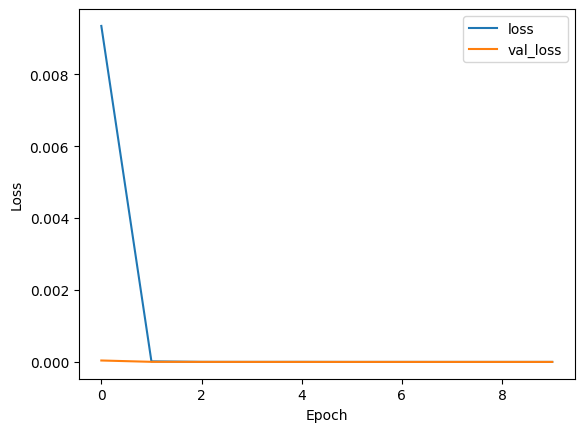

Testing the CNN model...
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Function to load the violence dataset (you need to adjust the path)
def load_violence_dataset(path):
    videos = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        print(f"Processing folder: {folder_path}")
        if os.path.isdir(folder_path):
            label = 1 if 'violence' in folder.lower() else 0  # 1: Violence, 0: Non-violence
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png')):
                    image_path = os.path.join(folder_path, file)
                    try:
                        image = cv2.imread(image_path)
                        if image is None:
                            print(f"Failed to load image {image_path}. Skipping...")
                            continue

                        image = cv2.resize(image, (224, 224))  # Resize to the model input size
                        videos.append(image)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
                        continue
    videos = np.array(videos)
    labels = np.array(labels)
    return videos, labels

# Preprocess the dataset
def preprocess_data(images):
    images = images.astype('float32') / 255.0
    return images

# CNN Model
def create_cnn_model(input_shape):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flattening
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    return model

# Compile the model
def compile_cnn_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy',  # Binary classification
                  metrics=['accuracy'])

# Train the CNN model
def train_cnn_model(model, train_images, train_labels, val_images, val_labels):
    batch_size = 32
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_images, train_labels, 
                        validation_data=(val_images, val_labels),
                        epochs=10,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    return history

# Test the model and calculate performance metrics
def test_cnn_model(model, test_images, test_labels):
    predictions = model.predict(test_images)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    return predicted_labels, accuracy, precision, recall, f1

# Main function to execute the workflow
def main():
    dataset_path = r'archive\new_violence'  # Update with the actual dataset path
    
    # Load the dataset and labels
    images, labels = load_violence_dataset(dataset_path)
    images = preprocess_data(images)
    
    # Split into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    
    # Further split training data into training and validation sets (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    # Create and compile the CNN model
    input_shape = (224, 224, 3)
    cnn_model = create_cnn_model(input_shape)
    compile_cnn_model(cnn_model)
    
    # Train the CNN model
    print("Training the CNN model...")
    history = train_cnn_model(cnn_model, X_train, y_train, X_val, y_val)
    
    # Plot training history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Test the CNN model and calculate accuracy, precision, recall, F1
    print("Testing the CNN model...")
    predicted_labels, accuracy, precision, recall, f1 = test_cnn_model(cnn_model, X_test, y_test)

if __name__ == "__main__":
    main()
